In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (6.4*2.5,4.8*3)
plt.rcParams["font.size"] = 15
from dsp import util
import json

Fs = 150e6/8/256

In [2]:
def process_scan(file, base='session'):
    path = f'session/{file}.json'
    with open(path, "r") as fp:
        data = json.load(fp)

    return data

In [3]:
#path = 'sysid7706'
#path = 'sysid8364'
path = 'sysid5206'

data = process_scan(path)
P = data["app"]["settings"]["periods"]
M = data["app"]["settings"]["realizations"]
windows = data["app"]["windows"]
Nprd = 504

u = data["1"]
y = data["7"]

In [4]:
print(len(u), len(y))
cycles = len(u)//P//M
print(f'P={P}, M={M}, C={len(u)//P//M}')

3571 4087
P=20, M=10, C=17


In [5]:
ix = M*P-1
N = 504
Nfft = 504
#figs, axs = plt.subplots(2, 1)
#axs[0].plot(u[ix], color='blue')
#axs[0].plot(len(u[ix]) + np.arange(len(u[ix+1])), u[ix+1], color='green')
#axs[0].plot(len(u[ix])*2 + np.arange(len(u[ix+2])), u[ix+2], color='orange')

#axs[1].plot(y[ix], color='blue')
#axs[1].plot(len(y[ix]) + np.arange(len(y[ix+1])), y[ix+1], color='green')
#axs[1].plot(len(y[ix])*2 + np.arange(len(y[ix+2])), y[ix+2], color='orange')

In [6]:
print(P, M, cycles)

20 10 17


C:\Users\mahdi\AppData\Local\Temp/ipykernel_11092/938407098.py:78: RuntimeWarning: invalid value encountered in square
  U_mnorm = U_m[c-1]**2
C:\Users\mahdi\AppData\Local\Temp/ipykernel_11092/938407098.py:81: RuntimeWarning: invalid value encountered in multiply
  YU_mnorm = Y_m[c-1] * np.conj(U_m[c-1])
C:\Users\mahdi\AppData\Local\Temp/ipykernel_11092/938407098.py:84: RuntimeWarning: invalid value encountered in true_divide
  t1 = Y_var[c-1] / Y_mnorm
C:\Users\mahdi\AppData\Local\Temp/ipykernel_11092/938407098.py:85: RuntimeWarning: invalid value encountered in true_divide
  t2 = U_var[c-1] / U_mnorm
C:\Users\mahdi\AppData\Local\Temp/ipykernel_11092/938407098.py:86: RuntimeWarning: invalid value encountered in true_divide
  t3 = 2*np.real(YU_covar[c-1] / YU_mnorm)
C:\Users\mahdi\AppData\Local\Temp/ipykernel_11092/938407098.py:89: RuntimeWarning: divide by zero encountered in true_divide
  t1 = Y_svar[c-1] / Y_mnorm
C:\Users\mahdi\AppData\Local\Temp/ipykernel_11092/938407098.py:89: Ru

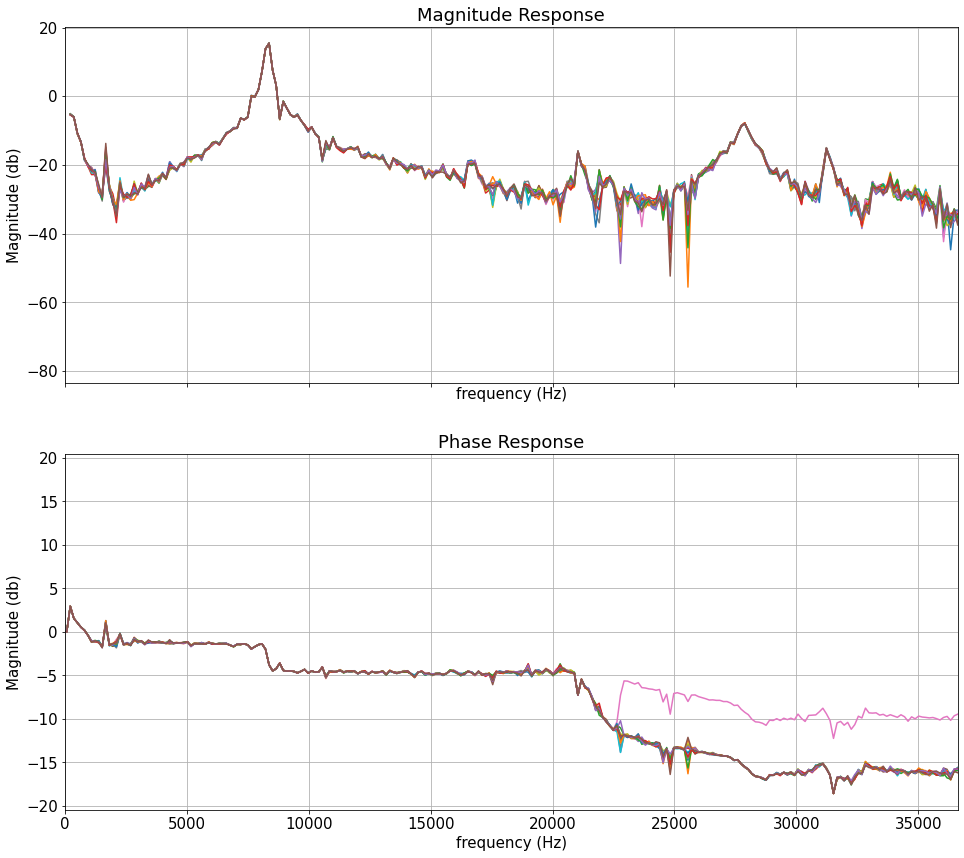

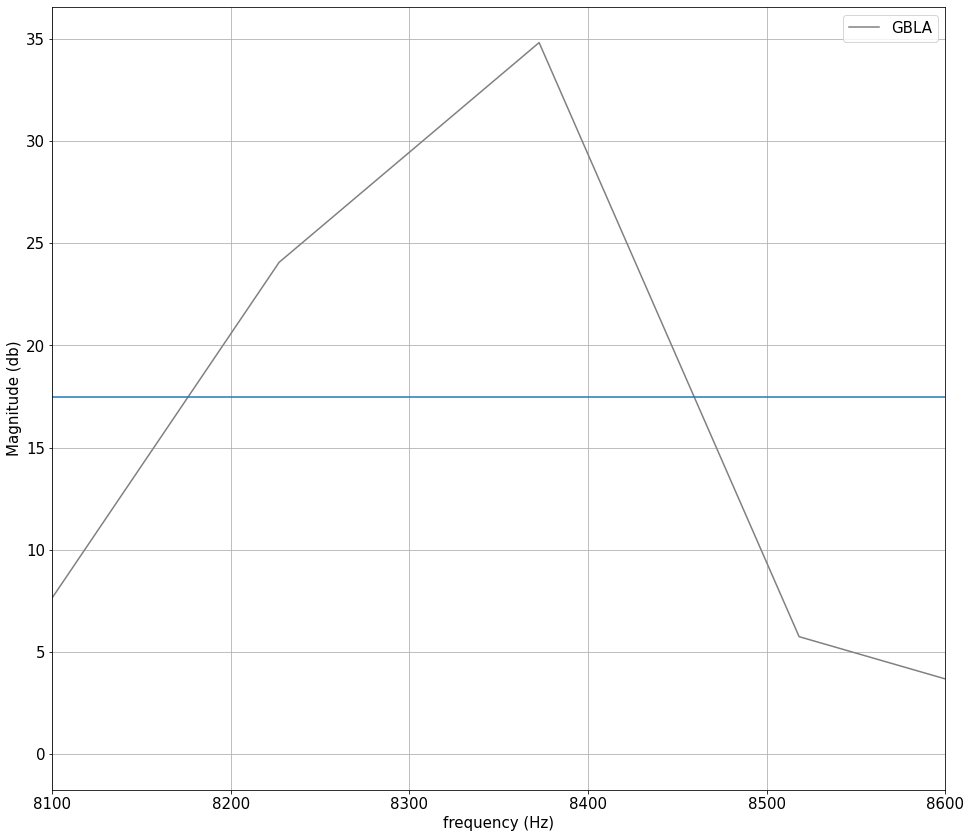

In [7]:
from dsp import util
import itertools

Y_m = np.zeros((cycles-1, Nfft), dtype=complex)
U_m = np.zeros((cycles-1, Nfft), dtype=complex)

Gbla = np.zeros((cycles-1, Nfft), dtype=complex)
YU_covar = np.zeros((cycles-1, Nfft), dtype=complex)
Y_var = np.zeros((cycles-1, Nfft), dtype=complex)
U_var = np.zeros((cycles-1, Nfft), dtype=complex)
YU_scovar = np.zeros((cycles-1, Nfft), dtype=complex)
Bla_noise_var = np.zeros((cycles-1, Nfft), dtype=complex)
Bla_total_var = np.zeros((cycles-1, Nfft), dtype=complex)
S_var2 = np.zeros((cycles-1, Nfft), dtype=complex)
S_outvar = np.zeros((cycles-1, Nfft), dtype=complex)
Y_svar = np.zeros((cycles-1, Nfft), dtype=complex)
U_svar = np.zeros((cycles-1, Nfft), dtype=complex)

Gmag = np.zeros(Nfft)
Gphase = np.zeros(Nfft)
fig, ax = plt.subplots(2, sharex=True)
ax[0].set_title('Magnitude Response')
ax[1].set_title('Phase Response')
ax[0].set_xlabel('frequency (Hz)')
ax[1].set_xlabel('frequency (Hz)')
ax[0].set_ylabel('Magnitude (db)')
ax[1].set_ylabel('Magnitude (db)')
ax[0].grid(True)
ax[1].grid(True)

for c in range(1, cycles):
	Y_p = np.zeros((M, Nfft), dtype=complex)
	U_p = np.zeros((M, Nfft), dtype=complex)
	YU_svar = np.zeros((M, Nfft), dtype=complex)
	Y_m_svar = np.zeros((M, Nfft), dtype=complex)
	U_m_svar = np.zeros((M, Nfft), dtype=complex)
	for m in range(M):
		uwins = np.array(u[c*M*P+m*P:c*M*P+(m+1)*P])
		ywins = np.array(y[c*M*P+m*P:c*M*P+(m+1)*P])
		uwins = uwins - np.mean(uwins, axis=1).reshape(P, 1)
		ywins = ywins - np.mean(ywins, axis=1).reshape(P, 1)
		uwins /= 2048
		ywins /= 2048
		m1phase = windows[m][2]
		phase = np.concatenate((np.flip(m1phase), [0], m1phase[:-1]))

		U_p_m = 2*np.pi*np.fft.fftshift(np.fft.fft(uwins, Nfft, norm="ortho"))
		Y_p_m = 2*np.pi*np.fft.fftshift(np.fft.fft(ywins, Nfft, norm="ortho"))
		U_p_avg = 1 / P * np.sum(U_p_m, axis=0, dtype=complex)
		Y_p_avg = 1 / P * np.sum(Y_p_m, axis=0, dtype=complex)
		U_p[m,:] = U_p_avg * phase
		Y_p[m,:] = Y_p_avg * phase

		YU_svar[m,:] = 1 / P / (P - 1) * np.sum((Y_p_m - Y_p_avg) * np.conj(U_p_m - U_p_avg), axis=0, dtype=complex)
		U_m_svar[m,:] = 1 / P / (P - 1) * np.sum(np.abs(U_p_m)**2, axis=0, dtype=complex) - np.abs(U_p_avg)**2
		Y_m_svar[m,:] = 1 / P / (P - 1) * np.sum(np.abs(Y_p_m)**2, axis=0, dtype=complex) - np.abs(Y_p_avg)**2

	U_m[c-1,:] = 1 / M * np.sum(U_p, axis=0, dtype=complex)
	Y_m[c-1,:] = 1 / M * np.sum(Y_p, axis=0, dtype=complex)
	YU_scovar[c-1,:] = 1 / M**2 * np.sum(YU_svar, axis=0, dtype=complex)
	Y_svar[c-1,:] = 1 / M**2 * np.sum(Y_m_svar, axis=0, dtype=complex)
	U_svar[c-1,:] = 1 / M**2 * np.sum(U_m_svar, axis=0, dtype=complex)

	U_corr = U_p - U_m[c-1]
	Y_corr = Y_p - Y_m[c-1]

	U_var[c-1,:] = 1 / M / (M - 1) * np.sum(np.abs(U_p)**2, axis=0, dtype=complex) - np.abs(U_m[c-1])**2
	Y_var[c-1,:] = 1 / M / (M - 1) * np.sum(np.abs(Y_p)**2, axis=0, dtype=complex) - np.abs(Y_m[c-1])**2
	YU_covar_m = Y_corr * np.conj(U_corr)
	#print(f"YU_covar_m {YU_covar_m.shape}")
	YU_covar[c-1,:] = 1 / M / (M - 1) * np.sum(YU_covar_m, axis=0, dtype=complex)

	U_m[c-1,U_m[c-1] == 0] = np.inf
	Gbla[c-1,:] = np.divide(Y_m[c-1], U_m[c-1])
	#Gbla[c-1][Gbla[c-1] == 0] = np.nan

	Y_mnorm = Y_m[c-1]**2
	U_mnorm = U_m[c-1]**2
	#Y_mnorm[Y_mnorm == 0] = np.inf
	#U_mnorm[U_mnorm == 0] = np.inf
	YU_mnorm = Y_m[c-1] * np.conj(U_m[c-1])
	#YU_mnorm[YU_mnorm == 0] = np.inf

	t1 = Y_var[c-1] / Y_mnorm
	t2 = U_var[c-1] / U_mnorm
	t3 = 2*np.real(YU_covar[c-1] / YU_mnorm)
	Bla_total_var[c-1,:] = Gbla[c-1]**2 * (t1 + t2 - t3)

	t1 = Y_svar[c-1] / Y_mnorm
	t2 = U_svar[c-1] / U_mnorm
	t3 = 2*np.real(YU_scovar[c-1] / YU_mnorm)
	Bla_noise_var[c-1,:] = Gbla[c-1]**2 * (t1 + t2 - t3)

	S_var2[c-1,:] = M*(Bla_total_var[c-1] - Bla_noise_var[c-1])
	S_var2[c-1, Bla_total_var[c-1] < Bla_noise_var[c-1]] = 0

	S_outvar[c-1:,] = U_m[c-1]**2 * S_var2[c-1]
	#plt.plot(10*np.log10(np.abs(U_m)**2))
	#plt.plot(10*np.log10(np.abs(Y_m)**2))
	#plt.figure()

	mag = 10*np.log10(np.abs(Gbla[c-1])**2)
	phase = np.angle(Gbla[c-1])[252:]
	unwrapped = util.unwrap_spectral_phase(phase)
	phase = np.concatenate((-1*np.flip(unwrapped), unwrapped))

	ax[0].plot(np.linspace(-Fs/2, Fs/2, Nfft), mag)
	ax[1].plot(np.linspace(-Fs/2, Fs/2, Nfft), phase)
	# 2-sample running sum
	Gmag += mag
	Gmag /= 2
	Gphase += phase
	Gphase /= 2

ax[0].set_xlim(0, Fs/2)
ax[1].set_xlim(0, Fs/2)
bla2 = []
bla = []
iov = []
#iov.append((False, "U_noise", np.mean(U_svar, axis=0, dtype=complex)))
#iov.append((False, "Y_noise", np.mean(Y_svar, axis=0, dtype=complex)))
#iov.append((False, "YU_variance", np.mean(YU_scovar, axis=0, dtype=complex)))

#iov.append((False, "GBLA_variance", np.mean(Bla_noise_var, axis=0, dtype=complex)))
#iov.append((True, "GBLA_noise", np.mean(Bla_total_var, axis=0, dtype=complex)))

#bla.append((False, "GBLA_noise", np.mean(np.abs(Bla_total_var)**2, axis=0, dtype=complex)))
#bla.append((False, "G_S", np.mean(np.abs(S_var2)**2, axis=0, dtype=complex)))
#ov.append((False, "Y_noise", np.mean(Y_svar, axis=0, dtype=complex)))

final_GBLA = np.mean(np.abs(Gbla)**2, axis=0, dtype=complex)
#bla.append((False, "YU_noise", np.mean(YU_covar, axis=0, dtype=complex)))
#bla.append((False, "Y_S", np.mean(np.abs(S_outvar)**2, axis=0, dtype=complex)))
##bla.append((False, "GBLA_variance", np.mean(np.abs(Bla_noise_var), axis=0, dtype=complex)))
#bla.append((False, "YU_sample_noise", np.mean(YU_scovar, axis=0, dtype=complex)))

#bla.append((True, "G", np.mean(np.abs(S_var2)**2, axis=0, dtype=complex)))
#iov.append((True, "G_Sp", np.mean(np.abs(YU_covar)**2, axis=0, dtype=complex)))


#final_GBLApre = np.abs(np.mean(Gbla, axis=0, dtype=complex))**2
#bla.append((True, "pGBLA", final_GBLApre))
#bla.append((True, "GBLAp", final_GBLApost))

#iov.append((False, "U_variance",np.mean(U_var, axis=0, dtype=complex)))
#iov.append((False, "Y_variance", np.mean(Y_var, axis=0, dtype=complex)))

#amp[amp == 0] = np.inf
#YU_mag = 10*np.log10(amp**2)
#YU_mag[YU_mag.size // 2] = YU_mag[YU_mag.size // 2 + 1]
fig, ax = plt.subplots(1)
support = np.linspace(-Fs/2, Fs/2, Nfft)
ax.grid(True)
#ax[1].grid(True)
#ax[0].plot(support, 2*Gmag[Nfft//2+1:], label="GBLA response")
#ax[0].plot(support, final_GBLA, label="GBLA", color="grey")
ax.plot(support, final_GBLA, label="GBLA", color="grey")
for amp in bla:
	ax.plot(support, (20 if amp[0] else 10)*np.log10(np.abs(amp[2])), label=amp[1])
#for amp in iov:
	#ax[1].plot(support, (20 if amp[0] else 10)*np.log10(np.abs(amp[2])), label=amp[1])
ax.legend()
#ax[1].legend()
#ax.set_xlim(500, support[-1])
ax.set_xlim(8100, 8600)
#ax[1].set_xlim(500, support[-1])
ax.set_xlabel('frequency (Hz)')
#ax[1].set_xlabel('frequency (Hz)')
ax.set_ylabel('Magnitude (db)')
#ax[1].set_ylabel('Magnitude (db)')
ax.grid(True)
#ax[1].grid(True)
ax.axhline(35/2)
plt.show()
